In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Looking at the data

In [3]:
df_3 = pd.read_csv('data\station_40.csv')
df_1 = pd.read_csv('data\station_49.csv')
df_4 = pd.read_csv('data\station_63.csv')
df_2 = pd.read_csv('data\station_80.csv')

In [4]:
df_3.head()

,YEAR,W_1,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9,W_10,W_11,W_12,W_13,W_14,W_15,W_16,W_17,W_18,YIELD
0,0,21.389266,26.985066,23.813756,26.852214,25.096705,26.852109,25.730293,23.416002,21.038240,5.739711,2.787364,1.843174,1.549155,0.394481,2.868049,1.587736,3.046101,2.680206,10.32
1,1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,3.610893,2.148366,2.317832,0.822936,2.606934,1.883197,1.297795,7.477726,10.39
2,2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,1.872529,4.237160,0.086909,1.460638,2.163314,7.340032,3.863088,2.659763,8.49
3,3,20.553688,20.992986,22.859027,28.654018,26.705206,24.458350,25.146936,21.531644,22.961974,8.479863,5.067890,3.836785,0.239243,0.113061,3.535262,4.748053,0.914197,0.926442,7.28
4,4,21.523342,21.542900,23.034072,26.327315,30.362289,27.503657,27.839165,29.764479,18.290963,3.405621,0.363119,1.941876,0.259491,0.814974,1.240040,0.611056,1.746779,1.708829,7.31


<Axes: >

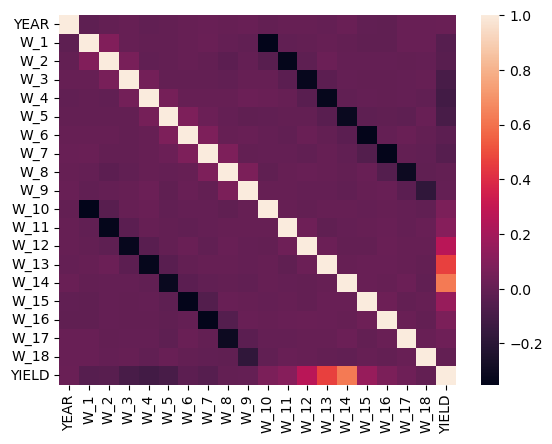

In [5]:
sns.heatmap(df_1.corr())
# On voit que yield particulièrement coorélé avec W_12 - W_16 (pluie sur juin - septembre)
# On voit que à chaque fois W_i négativement corrélé avec w_{i+9} (chaud négativement corrélé avec pluie)
# On voit que légèrement corrélé avec ses voisins

In [6]:
import ydata_profiling
# df_1.profile_report() 

# On voit que les W_1 - W_9 sont Gaussiens, en revanche les W_10-W_18 suivent plutôt une loi gamma
# YIELD suit une loi normale, mais plafonnée à 15,75

In [7]:
import plotly.express as px
fig = px.histogram(df_1, x="W_14")
fig.show()

In [8]:
import plotly.figure_factory as ff
fig = ff.create_distplot([df_1["W_14"]], ["distplot"], bin_size=0.05)
fig.show()

c:\Users\User\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



## Can we predict Y from the W?

In [9]:
from sklearn.model_selection import train_test_split

target_40 = df_3["YIELD"]
data_40 = df_3.drop(columns=["YIELD", "YEAR"])

data_train_40, data_test_40, target_train_40, target_test_40 = train_test_split(
    data_40, target_40, test_size = 0.2, random_state=42
)

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), Ridge())

pipe.fit(data_train_40, target_train_40)
prediction = pipe.predict(data_test_40)
mean_squared_error(prediction, target_test_40)

1.676210963277208

In [11]:
df_3["YIELD"].mean()

11.395634

In [12]:
pipe[1].coef_

array([ 5.56217199e-02, -5.35597327e-03, -8.39011061e-02, -8.73101069e-02,
       -1.58169306e-02, -1.05649513e-01, -7.90303247e-02,  9.50654643e-03,
        2.64795112e-03, -2.61796297e-01, -2.26961946e-01,  4.32330123e-01,
        1.07582409e+00,  1.06188551e+00,  6.40455530e-01,  2.92374804e-01,
       -2.64485142e-04, -1.10647025e-02])

In [13]:
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(data_train_40, target_train_40)
prediction = model.predict(data_test_40)
mean_squared_error(prediction, target_test_40) / df_3["YIELD"].mean()


0.11440102483639697

In [14]:
feature_importances = model.feature_importances_
features = np.vstack((np.array(data_train_40.columns),
                     np.array(feature_importances))).T
impor = pd.DataFrame(sorted(features, key=lambda x: x[1], reverse=True))
impor

,0,1
0,W_14,0.297234
1,W_13,0.265133
2,W_15,0.106825
3,W_12,0.093433
4,W_11,0.038478
5,W_16,0.038378
6,W_10,0.036781
7,W_3,0.012895
8,W_7,0.012499
9,W_5,0.012142


In [15]:
np.sum(impor[1][:3])

0.6691917032003403

# Looking at epsilon data only

In [17]:
Q = [3.3241, 5.1292, 6.4897, 7.1301]
mask = (df_1[["W_13", "W_14", "W_15"]].sum(axis=1) < Q[0]) & (df_2[["W_13", "W_14", "W_15"]].sum(axis=1) < Q[1]) & (df_3[["W_13", "W_14", "W_15"]].sum(axis=1) < Q[2]) & (df_4[["W_13", "W_14", "W_15"]].sum(axis=1) < Q[3])
df_1_part = df_1[mask]
df_2_part = df_2[mask]
df_3_part = df_3[mask]
df_4_part = df_4[mask]

df_1_part["Station"] = 1
df_2_part["Station"] = 2
df_3_part["Station"] = 3
df_4_part["Station"] = 4

df_1_part

,YEAR,W_1,W_2,W_3,W_4,W_5,W_6,W_7,W_8,W_9,...,W_11,W_12,W_13,W_14,W_15,W_16,W_17,W_18,YIELD,Station
1,1,21.430837,22.228488,24.205256,29.859199,30.434175,26.467017,27.300290,22.509277,16.388211,...,1.467149,1.357827,0.875649,0.305032,1.673852,0.214576,0.533683,1.496904,5.54,1
2,2,18.841767,25.165941,24.169267,28.742330,27.342035,27.945379,25.710641,22.343698,19.797961,...,0.381546,0.949828,0.220260,1.074115,0.040914,0.605979,0.559963,0.682941,4.39,1
10,10,23.067487,21.989987,26.730305,27.207224,28.277049,26.121537,30.583426,22.363784,15.826520,...,1.795475,0.345985,0.382794,0.215382,1.725849,0.083205,1.516085,2.485251,4.07,1
28,28,24.441997,24.273763,23.400111,27.344886,25.011067,28.047828,25.841452,20.996116,16.747943,...,0.263892,3.241495,0.605714,0.141720,0.940132,0.281891,0.767335,1.129858,4.77,1
33,33,21.562630,22.283709,25.263382,25.713687,28.258033,28.984649,26.601343,23.831066,17.453389,...,1.806542,3.405140,1.460973,0.299190,1.387668,1.086085,0.664143,2.649646,4.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,9932,20.727074,21.049957,22.076089,24.532930,27.892463,27.492863,28.687003,22.284578,18.464562,...,0.511038,3.191038,0.971027,0.765645,0.450004,0.135279,0.693551,1.936565,5.94,1
9961,9961,18.227577,28.465454,24.221706,23.768921,27.306393,28.379903,25.283359,22.363430,17.239503,...,0.311604,0.690322,1.342535,0.617727,0.725443,0.590940,1.258960,1.732204,4.00,1
9987,9987,18.393095,18.849918,24.745502,25.614881,26.017482,25.460018,22.976764,18.977460,17.655078,...,2.215472,2.410025,0.106265,1.116415,0.216162,0.725135,0.172526,1.004489,4.32,1
9996,9996,17.775542,21.499263,22.323207,27.072953,25.665768,29.337247,27.551202,22.894673,15.346937,...,1.630360,1.645829,0.111998,1.125856,0.169407,1.167883,0.912262,1.201698,4.55,1


In [18]:
# df_1_part.profile_report() 


## Simulating Y with Gaussian models by hand

In [25]:
print(df_4_part["YIELD"].mean())
print(df_4_part["YIELD"].std())

3.3169299999999997
1.9272543123013854


In [26]:
def yield_4_gen():
    res = np.random.normal(3.32, 1.87, 1000)
    return (res > 0) * res

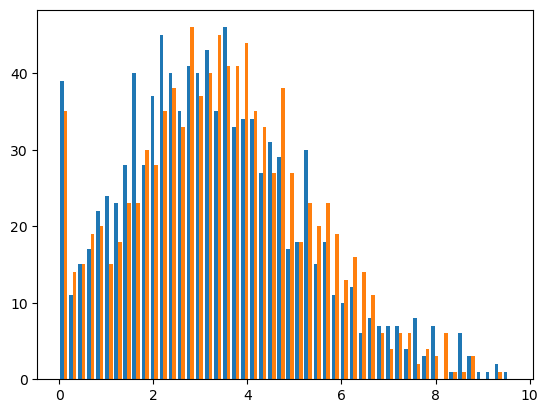

In [27]:
plt.hist([df_4_part["YIELD"], yield_4_gen()], bins=50)
plt.show()

In [28]:
def yield_2_gen():
    simul = np.stack((np.random.normal(7.5, 1.5, 1000), np.random.normal(5, 1, 1000)))
    random = np.random.randint(0, 2, 1000)
    return [simul[random[i], i] for i in range(1000)]


[]

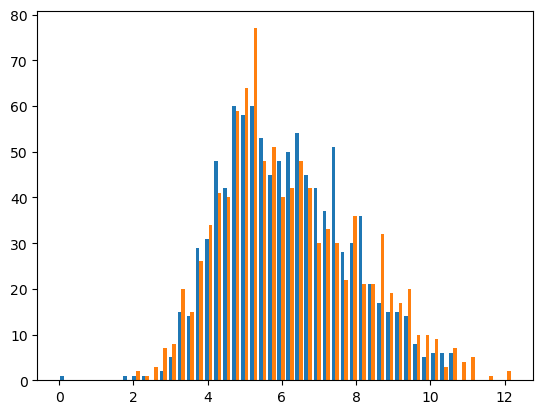

In [29]:
plt.hist([df_2_part["YIELD"], yield_2_gen()], bins=50)
plt.plot()

[]

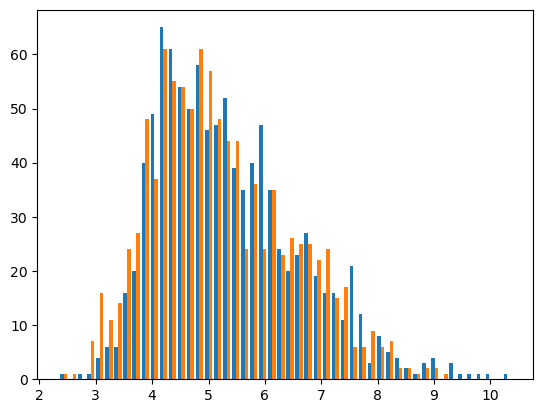

In [30]:
def yield_1_gen():
    simul = np.stack((np.random.normal(6, 1.2, 1000), np.random.normal(4.5, 0.7, 1000)))
    random = np.random.randint(0, 2, 1000)
    return [simul[random[i], i] for i in range(1000)]

plt.hist([df_1_part["YIELD"], yield_1_gen()], bins=50)
plt.plot()

[]

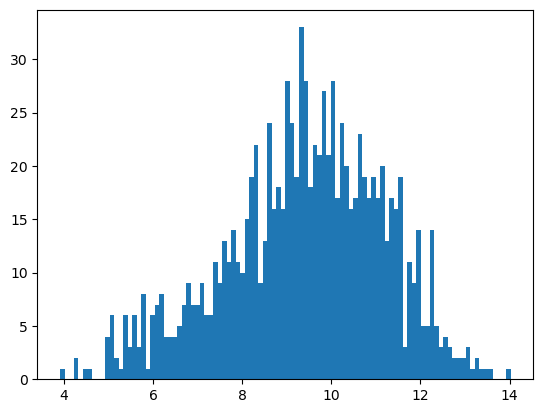

In [31]:
plt.hist([df_3_part["YIELD"]], bins=100)
plt.plot()

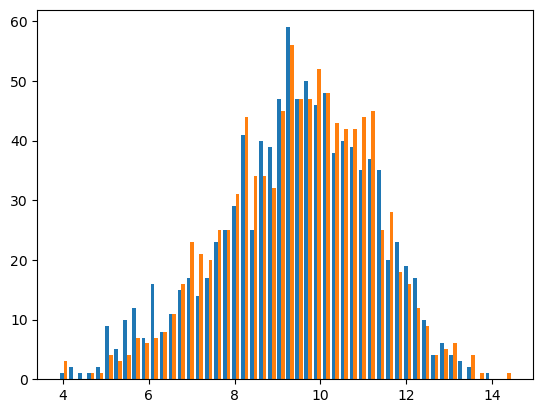

In [32]:
def yield_3_gen():
    simul = np.stack((np.random.normal(10.5, 1.2, 1000), np.random.normal(8.3, 1.5, 1000)))
    random = np.random.randint(0, 2, 1000)
    return [simul[random[i], i] for i in range(1000)]

plt.hist([df_3_part["YIELD"], yield_3_gen()], bins=50)
plt.show()


In [33]:
##### CHECKING THAT IT WORKS

import ot

gen_yields = np.stack((yield_1_gen(), yield_2_gen(), yield_3_gen(), yield_4_gen())).T
subset_yields = pd.read_csv('CSVs/yields_subset.csv').iloc[:, 2:]

yield_1_true = subset_yields.to_numpy()

print(ot.sliced.sliced_wasserstein_distance(yield_1_true, gen_yields, seed=0))

0.21463431721666093


# Making a clean Gaussian Mixture Model

In [186]:
df_1234 = pd.read_csv('CSVs/yields_subset.csv').iloc[:, 2:]

In [187]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4, n_init=10)
gm.fit(df_1234)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

GaussianMixture(n_components=4, n_init=10)

In [36]:
print(f"weights: {gm.weights_}")
print(f"means: {gm.means_}")
print(f"cov: {gm.covariances_}")

weights: [0.27715344 0.20096278 0.29128935 0.23059443]
means: [[ 5.86139258  5.47258616 10.01731076  2.37522567]
 [ 6.22803832  7.54221428  9.94444073  5.41015488]
 [ 4.45036279  5.89044195  9.00801259  2.03327243]
 [ 5.17140725  6.16101857  8.63111601  4.24605948]]
cov: [[[ 1.37311213  0.37050471 -0.1220308  -0.13597099]
  [ 0.37050471  1.48607932  0.04623979  0.38212167]
  [-0.1220308   0.04623979  2.10485304  0.08260514]
  [-0.13597099  0.38212167  0.08260514  1.53346726]]

 [[ 2.00022227  0.09349971  0.55859889 -0.58626785]
  [ 0.09349971  2.63946873  0.30244702  0.14417689]
  [ 0.55859889  0.30244702  2.42219462 -0.84805622]
  [-0.58626785  0.14417689 -0.84805622  3.54088705]]

 [[ 0.33173435  0.05435465  0.17715039 -0.09603362]
  [ 0.05435465  2.44814558  0.64228091  1.16399535]
  [ 0.17715039  0.64228091  3.3856295   0.17516865]
  [-0.09603362  1.16399535  0.17516865  1.5199807 ]]

 [[ 1.02678545  0.30980978 -0.20535768 -0.41943644]
  [ 0.30980978  2.72618676  0.11910392 -0.2126

In [188]:
simul = gm.sample(1000)[0]
simul[:, 3] = simul[:, 3] * (simul[:, 3] > 0)

In [192]:
simul.std(axis=0)

array([1.31873255, 1.63193207, 1.76663013, 1.88897885])

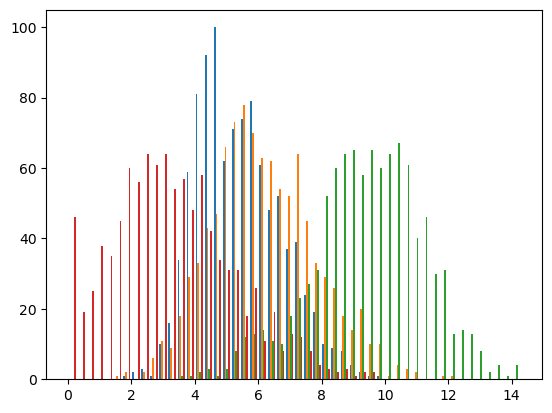

In [190]:
plt.hist(simul, bins = 50)
plt.show()

In [39]:
yield_1_true = pd.read_csv('CSVs/yields_subset.csv').iloc[:, 2:].to_numpy()

print(ot.sliced.sliced_wasserstein_distance(yield_1_true, simul, seed=0))

0.13921927204833545


In [40]:
def GMM_generator(n_components):
    gm = GaussianMixture(n_components=n_components, n_init=10)
    gm.fit(df_1234)
    simul = gm.sample(1000)[0]
    simul[:, 3] = simul[:, 3] * (simul[:, 3] > 0)
    return gm, simul

print(ot.sliced.sliced_wasserstein_distance(yield_1_true, GMM_generator(4)[1], seed=0))

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

0.10839440210965127


#### Tuning the number of Gaussian cores

In [53]:
# Tuning the number of components with 10-CV

dico = {i : {"AIC": 0, "SWD" :0} for i in range(1, 13)}
for n_components in range(1, 13):
    aic = []
    SWD = []
    for i in range (10):
        model, simul = GMM_generator(n_components)
        aic.append(model.aic(df_1234))
        SWD.append(ot.sliced.sliced_wasserstein_distance(yield_1_true, GMM_generator(4)[1], seed=0))   
    dico[n_components]["AIC"] = np.mean(aic)
    dico[n_components]["SWD"] = np.mean(SWD)
    print(n_components)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

1


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

2


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

3


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

4


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

5


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

6


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

7


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

8


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

9


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

10


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

11


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

12


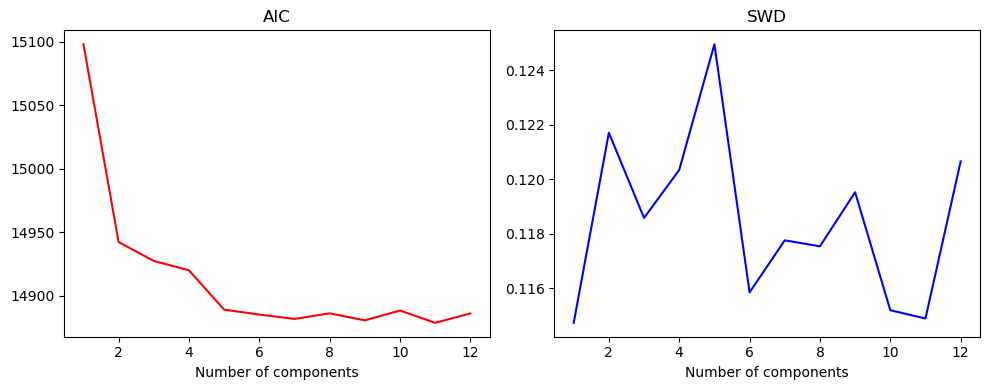

In [60]:
CV_results = pd.DataFrame(dico).T

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(CV_results["AIC"], 'r')
axs[0].set_title('AIC')
axs[0].set_xlabel("Number of components")

axs[1].plot(CV_results["SWD"], 'b')
axs[1].set_title(f'SWD')
axs[1].set_xlabel("Number of components")


plt.tight_layout()
plt.show()


### Bayesian Gaussian Mixture pour identifier le nombre optimal de components

In [41]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=20, n_init=20, random_state=42)
bgm.fit(df_1234)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

BayesianGaussianMixture(n_components=20, n_init=20, random_state=42)

In [42]:
bgm.weights_.round(2)
# On dirait que identifie 10 comme le nombre optimal de components

array([0.06, 0.07, 0.08, 0.16, 0.  , 0.15, 0.12, 0.17, 0.05, 0.09, 0.04,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [44]:
sum(bgm.weights_.round(2) > 0)

10

In [63]:
sum(bgm.weights_.round(1) > 0)

9

### Noise

In [287]:
from joblib import dump

gm = GaussianMixture(n_components=10, n_init=10)
gm.fit(df_1234)

dump(gm, 'gmm.joblib')

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

['gmm.joblib']

In [267]:
from joblib import load

loaded_model = load('gmm.joblib')

loaded_model.sample(1000)[0].std(axis =0)

array([1.26993511, 1.68993557, 1.79904351, 1.93383208])

In [268]:
loaded_model.weights_

array([0.1019525 , 0.10490759, 0.12401947, 0.05958884, 0.0722535 ,
       0.14947982, 0.05923292, 0.07199604, 0.1396718 , 0.11689752])

In [269]:
loaded_model.means_

array([[ 4.30185576,  6.75785476,  8.55541882,  2.84904684],
       [ 5.06207621,  7.76622065, 10.34832274,  4.32523567],
       [ 4.55917225,  4.66639319,  9.45772278,  1.64492153],
       [ 6.61959805,  7.71422685, 11.24225061,  5.3370553 ],
       [ 4.61382349,  5.06813336,  6.13861483,  2.41294194],
       [ 6.52834963,  6.27369049,  9.95059035,  2.67624874],
       [ 6.56055297,  7.0797344 ,  8.98951235,  6.81464809],
       [ 5.89252023,  7.88186641,  7.62819719,  3.83343955],
       [ 5.2089784 ,  4.75998377,  9.48056949,  4.33653992],
       [ 5.01145704,  5.74192144, 10.70603975,  1.6335358 ]])

In [270]:
loaded_model.covariances_

array([[[ 0.22424107,  0.08910975,  0.10182465, -0.04807806],
        [ 0.08910975,  1.48240614,  0.61172436,  0.44513826],
        [ 0.10182465,  0.61172436,  0.67026155,  0.27534306],
        [-0.04807806,  0.44513826,  0.27534306,  1.5548663 ]],

       [[ 0.51165666,  0.14478581, -0.16204096, -0.14911602],
        [ 0.14478581,  1.69370178,  0.3327489 ,  0.31987917],
        [-0.16204096,  0.3327489 ,  1.53335714, -0.79920791],
        [-0.14911602,  0.31987917, -0.79920791,  1.70870198]],

       [[ 0.4393349 ,  0.15563414, -0.11722594,  0.03075992],
        [ 0.15563414,  0.8211237 ,  0.28817335,  0.34170368],
        [-0.11722594,  0.28817335,  0.92213622,  0.22247582],
        [ 0.03075992,  0.34170368,  0.22247582,  1.0937508 ]],

       [[ 2.32863688,  1.19936006,  0.60286644, -1.46390224],
        [ 1.19936006,  4.30168723, -0.1207461 ,  1.0961746 ],
        [ 0.60286644, -0.1207461 ,  0.55620459, -0.46048891],
        [-1.46390224,  1.0961746 , -0.46048891,  4.6404029 ]],



In [282]:
weights = loaded_model.weights_
means = loaded_model.means_
covariances = loaded_model.covariances_

simul = np.zeros((4,10_000))
for j in range(10000):
    component_idx = np.random.choice(np.arange(len(weights)), p=weights)
    S = np.linalg.cholesky(covariances[component_idx])
    simul[:, j] = S @ noise[j, :] + means[component_idx]

simul = simul * (simul > 0)

In [286]:
simul.std(axis=1)

array([1.25440429, 1.65264329, 1.77817692, 1.89652191])

In [283]:
simul.T

array([[ 5.13925873,  3.76009518, 10.14251888,  5.39187677],
       [ 4.53883704,  5.67573672,  9.51425564,  4.41834876],
       [ 3.96694218,  4.03304424, 11.343222  ,  2.07832127],
       ...,
       [ 4.61100238,  7.20425722,  8.48679547,  6.28574545],
       [ 4.04547713,  6.37318487,  9.23190891,  5.67339946],
       [ 4.24175144,  7.01107944, 10.40537028,  3.31477991]])

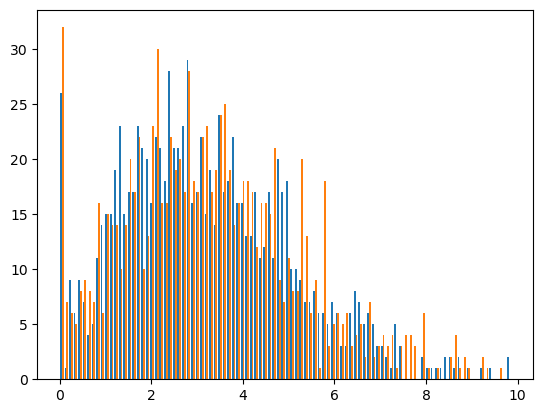

In [279]:
plt.hist([simul[3][:1000], df_1234["YIELD_4"]], bins=100)
plt.show()

In [151]:
df_1234.std(axis=0)

YIELD_1    1.260088
YIELD_2    1.680144
YIELD_3    1.791007
YIELD_4    1.927254
dtype: float64

In [141]:
simul = simul * (simul > 0)

(simul < 0).sum(axis = 1)


array([0, 0, 0, 0])

In [66]:
noise.shape

(10000, 50)

In [240]:
noise = np.load('data/noise.npy')[:, :4]

In [81]:
noise.shape

(10000, 4)

In [241]:
noise

array([[-0.07321885, -1.2355999 ,  0.4931525 ,  1.694539  ],
       [-0.7037753 ,  1.1012654 , -0.25281614, -0.7198674 ],
       [-0.893496  , -0.4839437 ,  2.206779  ,  0.446624  ],
       ...,
       [-1.3313594 , -0.02305795,  0.22361073, -1.302503  ],
       [-1.4187372 , -1.4799609 ,  1.7461216 ,  1.6347647 ],
       [-0.8920023 ,  0.8108433 ,  0.11112278,  1.1411965 ]],
      dtype=float32)

In [ ]:
#### garb

In [ ]:
np.stack((np.array(df_1_part["YIELD"]), npa.array(df_3_part["YIELD"]))).shape

(2, 1000)

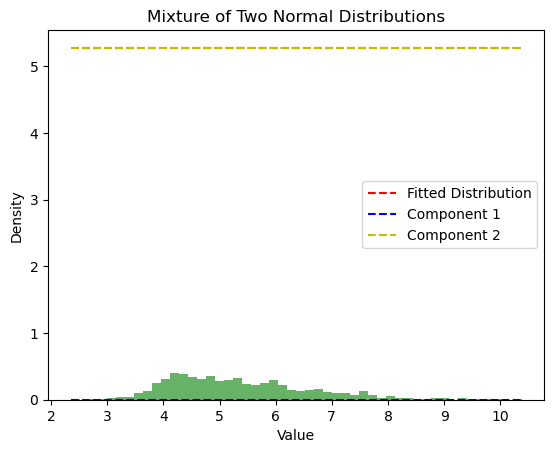

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit


# Define a mixture of two normal distributions
def gaussian(x, amp1, mean1, sigma1, amp2, mean2, sigma2):
    return (
        amp1 * norm.pdf(x, mean1, sigma1) +
        amp2 * norm.pdf(x, mean2, sigma2)
    )

# Initial guess for parameters
initial_params = [1, 10, 2, 1, 20, 3]

# Fit the model
params, covariance = curve_fit(gaussian, df_1_part["YEAR"], df_1_part["YIELD"], p0=initial_params)

# Plot the histogram of the data
plt.hist(df_1_part["YIELD"], bins=50, density=True, alpha=0.6, color='g')

# Plot the fitted distribution
x = np.linspace(min(df_1_part["YIELD"]), max(df_1_part["YIELD"]), 1000)
y_fit = gaussian(x, *params)
plt.plot(x, y_fit, 'r--', label='Fitted Distribution')

# Plot individual components (optional)
y1 = params[0] * norm.pdf(x, params[1], params[2])
y2 = params[3] * norm.pdf(x, params[4], params[5])
plt.plot(x, y1, 'b--', label='Component 1')
plt.plot(x, y2, 'y--', label='Component 2')

plt.legend()
plt.title('Mixture of Two Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [ ]:
params

array([ 1.49669996e+00, -9.87833004e+02,  1.01407764e+00,  3.65897261e+05,
        5.78150233e+03,  2.70455014e+04])

In [ ]:
np.random.normal(params[1], params[2], 1000)

array([-986.67735456, -987.42050676, -988.57198359, -986.93536578,
       -987.44833892, -986.28021749, -986.83126585, -987.31148796,
       -988.41638795, -987.38951744, -988.76842015, -987.45041103,
       -988.15220232, -988.23589037, -988.13270725, -988.05637288,
       -990.10599382, -987.60832498, -986.68418337, -986.96458834,
       -987.0669876 , -987.92308675, -988.99888247, -989.66538948,
       -987.61912779, -986.7511192 , -988.44259261, -987.2035928 ,
       -987.3238569 , -987.67445006, -986.5436934 , -988.89574223,
       -988.83265515, -988.8580499 , -987.35287634, -987.42934564,
       -987.46557166, -987.46246849, -987.61328496, -987.60548071,
       -986.87067108, -986.78694778, -988.24867485, -985.87020562,
       -987.60107689, -987.59359445, -988.80694818, -987.5520894 ,
       -987.97631265, -987.30675822, -987.35181247, -987.10378706,
       -987.42749144, -986.17928614, -987.69745819, -987.21146645,
       -987.41036078, -987.35322785, -988.47349702, -987.24195